# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EDA

### 1. portfolio dataset

In [2]:
portfolio.head(), portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


(   reward                      channels  difficulty  duration     offer_type  \
 0      10       [email, mobile, social]          10         7           bogo   
 1      10  [web, email, mobile, social]          10         5           bogo   
 2       0          [web, email, mobile]           0         4  informational   
 3       5          [web, email, mobile]           5         7           bogo   
 4       5                  [web, email]          20        10       discount   
 
                                  id  
 0  ae264e3637204a6fb9bb56bc8210ddfd  
 1  4d5c57ea9a6940dd891ad53e9dbe8da0  
 2  3f207df678b143eea3cee63160fa8bed  
 3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
 4  0b1e1539f2cc45b7b9fa7c272da2e1d7  ,
 None)

In [3]:
id_duplicates = portfolio['id'].duplicated().sum()
print('There is {} duplicates in offer id.'.format(id_duplicates))

There is 0 duplicates in offer id.


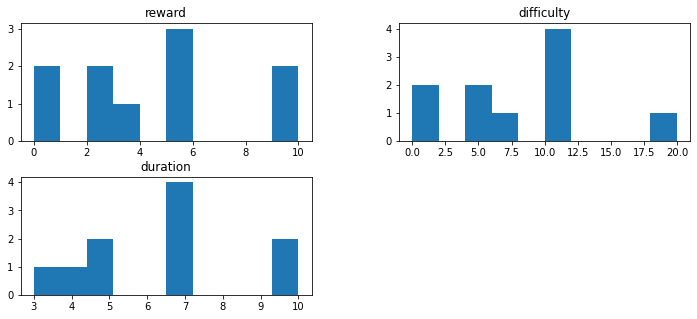

In [4]:
portfolio.hist(figsize=(12,5), grid=False);

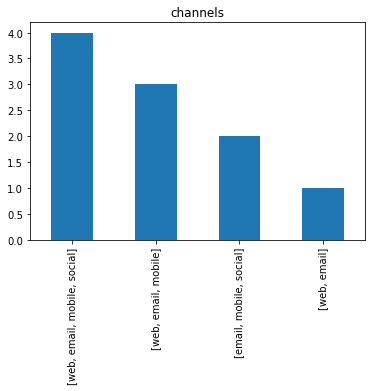

In [5]:
portfolio['channels'].value_counts().plot(kind='bar', title='channels');

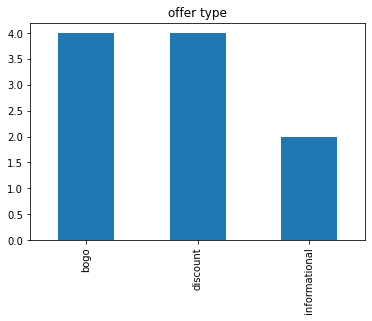

In [6]:
portfolio['offer_type'].value_counts().plot(kind='bar', title='offer type');

### 2. profile dataset

In [7]:
profile.head(), profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


(  gender  age                                id  became_member_on    income
 0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
 1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
 2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
 3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
 4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN,
 None)

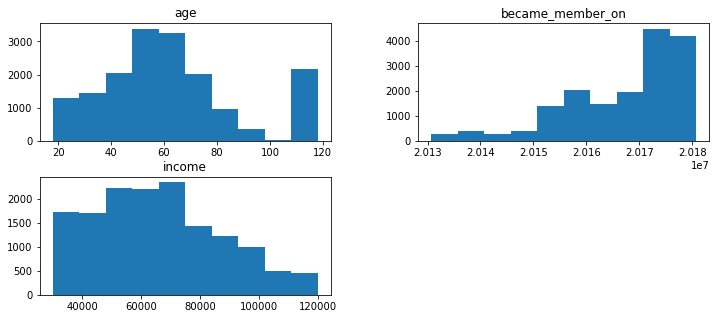

In [8]:
profile.hist(figsize=(12,5), grid=False);

In age distribution, there are some ages above 100, which doesn't seem to be correct.

In [9]:
# check and clean age over 100
profile[profile['age']>=100]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [10]:
# none values in age and income for ages over 100
profile[profile['age']>=100].isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
# drop rows when ages are over 100
drop_age = profile[profile['age']>=100].index

profile_new = profile.drop(axis=0, index=drop_age)
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14808 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14808 non-null  object 
 1   age               14808 non-null  int64  
 2   id                14808 non-null  object 
 3   became_member_on  14808 non-null  int64  
 4   income            14808 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.1+ KB


In [12]:
# after dropping ages over 100, there are no values any more
profile_new.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [13]:
# no duplicates in customer id
profile_new['id'].duplicated().sum()

0

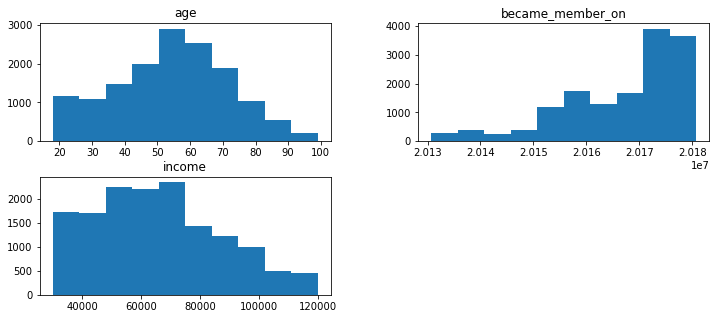

In [14]:
# distribution of numerical values seem better now
profile_new.hist(figsize=(12,5), grid=False);

In [15]:
profile_new.describe()

,age,became_member_on,income
count,14808.000000,1.480800e+04,14808.000000
mean,54.340829,2.016689e+07,65394.313884
std,17.323921,1.188748e+04,21595.072904
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,99.000000,2.018073e+07,120000.000000


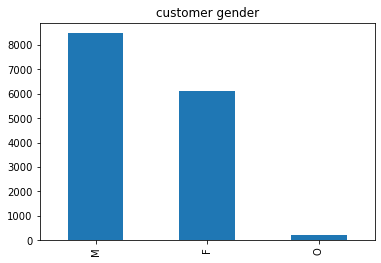

In [16]:
profile['gender'].value_counts().plot(kind='bar', title='customer gender');

### 3. transcript dataset

transcript data set is the interaction between profile and portfolio

In [17]:
transcript.head(), transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


(                             person           event  \
 0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
 1  a03223e636434f42ac4c3df47e8bac43  offer received   
 2  e2127556f4f64592b11af22de27a7932  offer received   
 3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
 4  68617ca6246f4fbc85e91a2a49552598  offer received   
 
                                               value  time  
 0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
 1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
 2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
 3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
 4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  ,
 None)

In [18]:
# duplicates in person
person_duplicate = transcript['person'].duplicated().sum()
person_unique = transcript['person'].nunique()
print('There are {} duplicates in person, due to different offers, there is {} unique customers'.format(person_duplicate, person_unique))

There are 289534 duplicates in person, due to different offers, there is 17000 unique customers


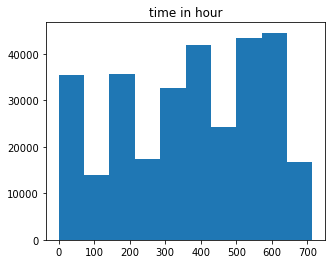

In [19]:
# distribution of numerical values seem better now
transcript.hist(figsize=(5,4), grid=False)
plt.title('time in hour');

Inconsistency of unit between portfolio duration and transcript test time.

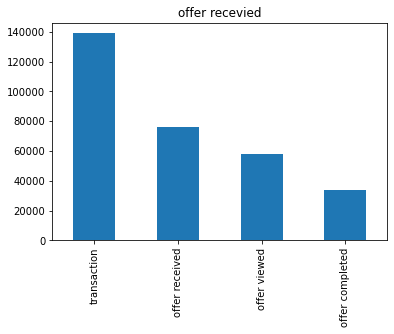

In [20]:
transcript['event'].value_counts().plot(kind='bar', title='offer recevied');

In [21]:
def clean_value_col():
    # split value column
    values = pd.json_normalize(transcript['value'])
    
    # get not null values in offer_id
    values_offer_id = values[values['offer id'].isnull()==False]
    
    # fill no
    filled_offers = values_offer_id.assign(offer_id=values_offer_id['offer id'])
    values_old = values.drop(values_offer_id.index, axis=0)
    values_new = values_old.append(filled_offers)
    values_new = values_new.drop(['offer id'], axis=1)
    
    return values_new

values_new = clean_value_col()

In [22]:
transcript = transcript.merge(values_new, how='inner', left_index=True, right_index=True)

transcript = transcript.drop(['value'], axis=1)

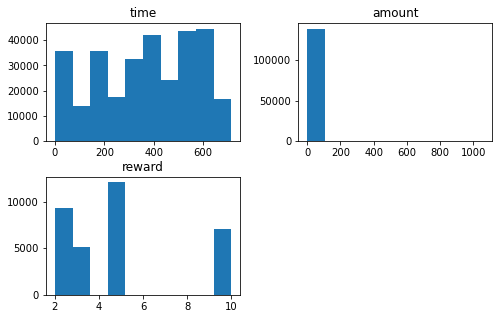

In [23]:
transcript.hist(figsize=(8,5), grid=False);

### 4. merge datasets

In [24]:
def concat_df():
    df = transcript.merge(profile_new, how='left', left_on='person', right_on='id')
    df = df.merge(portfolio, how='left', left_on ='offer_id', right_on='id')
    df = df.drop(['reward_y','id_x', 'id_y'], axis=1)
    df.rename(columns={'reward_x':'reward'}, inplace=True)
    df_new = df.sort_values(by=['person','time'])
    return df_new

df = concat_df()

In [25]:
df.head()

,person,event,time,amount,offer_id,reward,gender,age,became_member_on,income,channels,difficulty,duration,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,M,33.0,20170421.0,72000.0,"[email, mobile, social]",0.0,3.0,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,M,33.0,20170421.0,72000.0,"[email, mobile, social]",0.0,3.0,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN,M,33.0,20170421.0,72000.0,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,M,33.0,20170421.0,72000.0,"[web, email, mobile]",0.0,4.0,informational
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN,M,33.0,20170421.0,72000.0,"[web, email, mobile]",0.0,4.0,informational


### 5. Insights
In order to get some basic insights from the dataset, I will take a look at it from 2 aspects:
- Customer
- Offer

- Which offer type is the most difficult? Which reward the most?

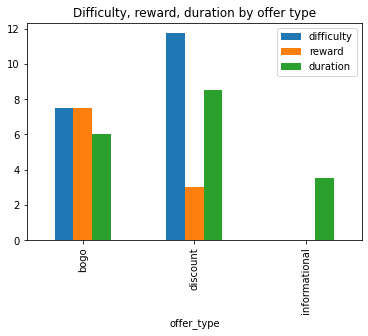

In [27]:
# set data
by_offer_type = portfolio.groupby(['offer_type'])[['difficulty','reward','duration']].mean()

# visualize
by_offer_type.plot(kind='bar')
plt.title('Difficulty, reward, duration by offer type');

Completion of discount is the most difficult, which also has the most duration and small rewards.

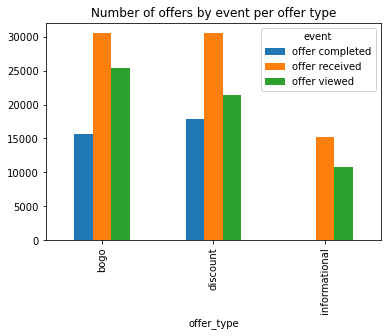

In [46]:
df.groupby(['offer_type','event'])['offer_id'].count().unstack().plot(kind='bar')
plt.title('Number of offers by event per offer type');

In terms of offers, no completed offer for informational events (no track of that), offer received is equal for discount and bogo, for offer viewed and offer completed, discount is slightly lower than bogo.

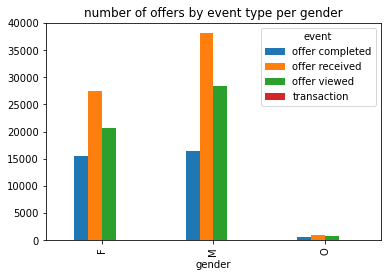

In [54]:
df.groupby(['gender','event'])['offer_id'].count().unstack().plot(kind='bar')
plt.title('number of offers by event type per gender');

It seems the pattern between female and male are the same for offer received, offer reviewed and offer completed. In terms of customer group, more males received/reviewed offers.

### Preparing data set

In [59]:
profile_age = pd.get_dummies(profile_new[['gender']])

In [60]:
profile_df_new = profile_ag

,gender_F,gender_M,gender_O
1,1,0,0
3,1,0,0
5,0,1,0
8,0,1,0
12,0,1,0
...,...,...,...
16995,1,0,0
16996,0,1,0
16997,0,1,0
16998,1,0,0


- Which feature is the most important to completing an offer?

In [29]:
df.head()

,person,event,time,amount,offer_id,reward,gender,age,became_member_on,income,channels,difficulty,duration,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,M,33.0,20170421.0,72000.0,"[email, mobile, social]",0.0,3.0,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,M,33.0,20170421.0,72000.0,"[email, mobile, social]",0.0,3.0,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN,M,33.0,20170421.0,72000.0,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,M,33.0,20170421.0,72000.0,"[web, email, mobile]",0.0,4.0,informational
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN,M,33.0,20170421.0,72000.0,"[web, email, mobile]",0.0,4.0,informational


In [31]:
by_offer = df.groupby(['offer_id','person','time','event'], as_index=False)['amount'].max()

In [ ]:
by_offer.sort_values(['person','time','offer_id'], ascending=True)